# Курс по машинному обучению,   ВМК МГУ
## SVM

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом задании есть новый тип задания -- ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

### Важно!

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**

__В этом задании вы..:__

- Изучите работу модели SVM
- Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
- Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)
- Узнаете про метод, который позволяет понижать число признаков и изучите его особенности на практике
- Научитесь корректировать выход модели SVM-классификатора, чтобы уметь получать вероятности

**А также..**

Если в ячейке написана фраза "Вывод", то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

In [2]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [3]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()
    
def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(size=(size1, 2)),
        np.random.normal(loc=2.0, size=(size2, 2))
    )]
    
    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [4]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1], 
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# 1. Разделяющая поверхность (1 балл)

В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.
    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [5]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

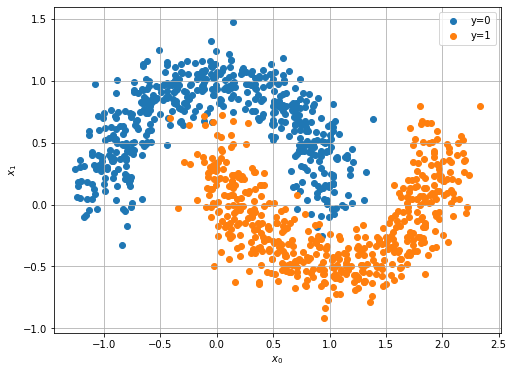

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

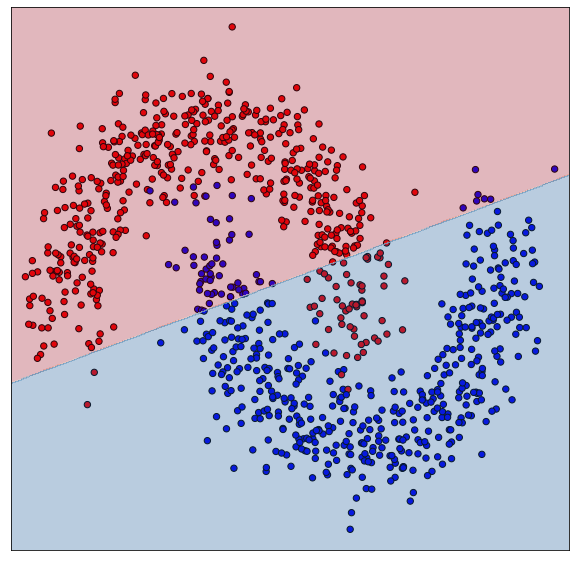

In [7]:
linear_svc.fit(X, y)
plot_separating_surface(X, y, linear_svc)

In [8]:
accuracy_score(y, linear_svc.predict(X))

0.878

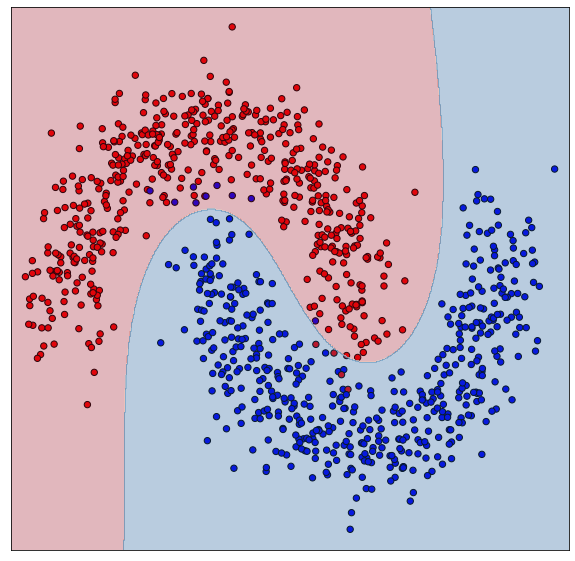

In [9]:
nonlinear_svc.fit(X, y)
plot_separating_surface(X, y, nonlinear_svc)

In [10]:
accuracy_score(y, nonlinear_svc.predict(X))

0.987

Сделайте вывод
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему? 

**Вывод:** Выборка линейно неразделима, поэтому модель с RBF ядром подходит лучше. Она показывает лучшую точность и разделяющая плоскость выглядит правильнее.

# 2. Опорные объекты (2 балла)

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим 
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достать опорные объекты из обученной модели можно с помощью поля model.support_.

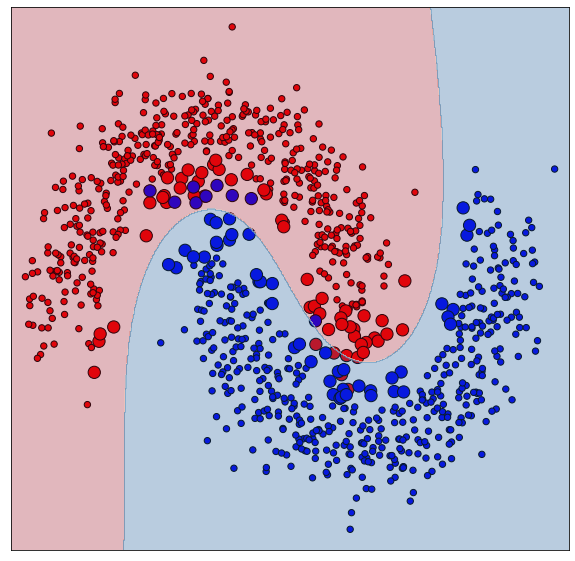

In [11]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

**Пункт 1**
Обучите новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [12]:
svc_on_linear_support = SVC(kernel='rbf')
svc_on_rbf_support = SVC(kernel='rbf')

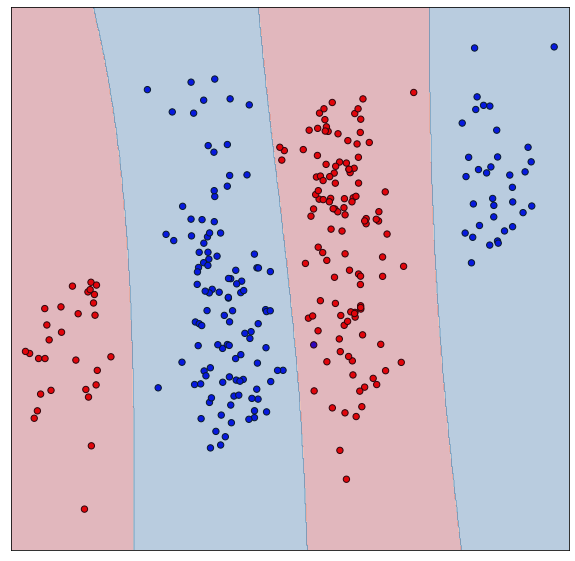

In [13]:
linear_support = linear_svc.support_
svc_on_linear_support.fit(X[linear_support], y[linear_support])
plot_separating_surface(X[linear_support], y[linear_support], svc_on_linear_support)

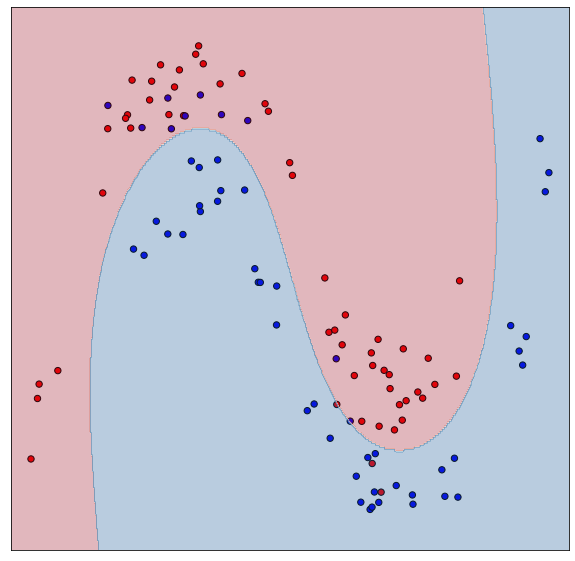

In [14]:
nonlinear_support = nonlinear_svc.support_
svc_on_rbf_support.fit(X[nonlinear_support], y[nonlinear_support])
plot_separating_surface(X[nonlinear_support], y[nonlinear_support], svc_on_rbf_support)

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из первой части. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе. 

**Вывод:** Модель, обученная на опорных векторах нелинейной модели более похожа на нелинейную модель. Она обучена на тех же векторах, на которых строилась нелинейная.

**Пункт 2** Обучите модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравните эту модель вместе с svc_on_rbf_support с нелинейной моделью из первой части (nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [15]:
svc_all_without_rbf_support = SVC(kernel='rbf')

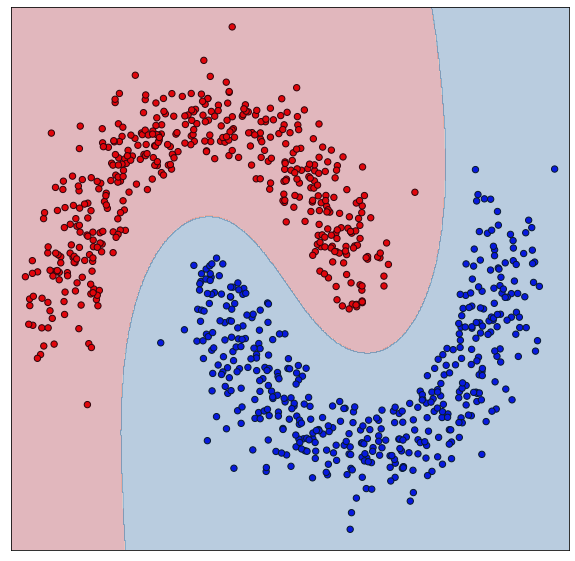

In [16]:
svc_all_without_rbf_support.fit(np.delete(X, nonlinear_support, axis=0), np.delete(y, nonlinear_support, axis=0))
plot_separating_surface(np.delete(X, nonlinear_support, axis=0), np.delete(y, nonlinear_support, axis=0), svc_all_without_rbf_support)

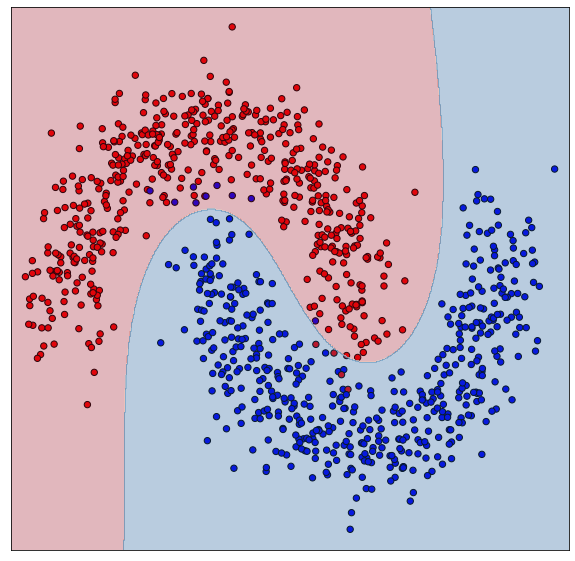

In [17]:
plot_separating_surface(X, y, nonlinear_svc)

Сильно ли полученные поверхности отличаются от той, что была получена в первой части? Что произошло с пограничными объектами? Объясните полученные результаты.

**Вывод:** Полученные поверхности отличаются слабо. Пограничные объекты были удалены, так как являлись опорными.

# 3. Форма разделяющей поверхности для несбалансированных классов (3 балла)

Формы разделяющих поверхностей могут быть вариативными для нелинейного случая. Один из способов влиять на форму поверхности -- это веса классов, которые задаются через параметр class_weight в sklearn.svm.SVC. Особенно это может быть полезно в задачах, где известно, что распределение классов в обучающей выборке отличается от реального. Такое свойственно медицинским данным, где в обучающих данных часто наблюдается перекос в сторону больных, так как именно их данные чаще собираются.
    
В данном задании вам будет дана выборка с несбалансированными данными. Кроме того, дана вторая выборка,
в которой классы имеют то же распределение, но классы имеют другое соотношение.  Вам нужно построить различные rbf-модели, меняя параметры весов классов и визуализировать разделяющие поверхности. Попробуйте улучшить 
качество на второй выборке (X_distr2, y_distr2), обучаясь только на первой (X_distr1, y_distr1) меняя параметры весов классов относительно дефолтных: class_weight={1: 1.0, 0: 1.0}.

In [18]:
X_distr1, y_distr1 = generate_data_with_imb_classes(100, 10)
X_distr2, y_distr2 = generate_data_with_imb_classes(10, 100)

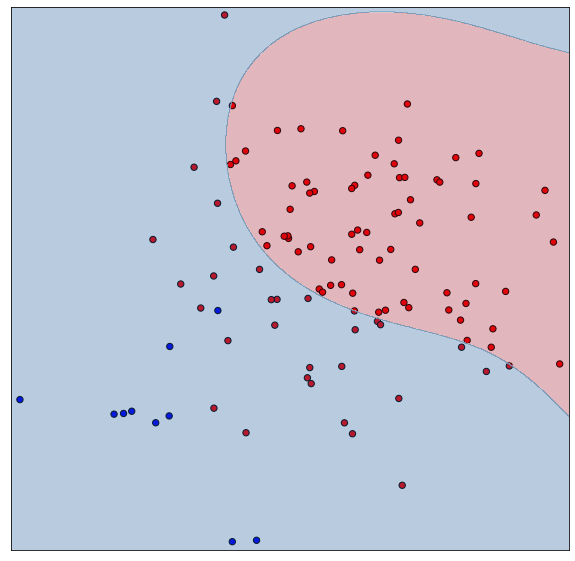

In [19]:
# Модель с дефолтными параметрами, которую Вам предстоит улучшить
base_model = SVC()
base_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, base_model)

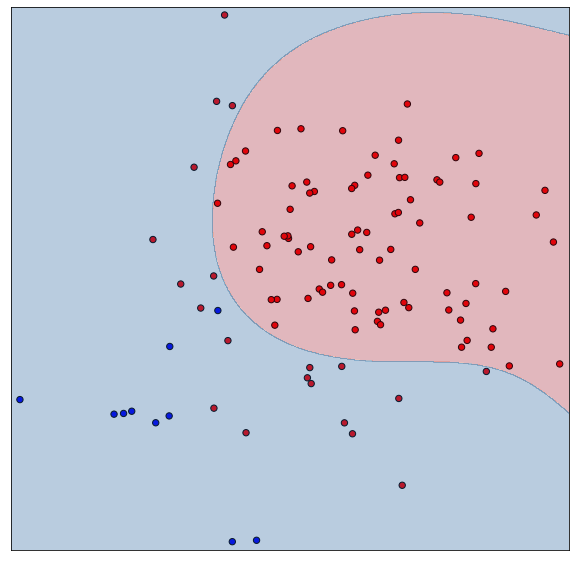

In [20]:
upg_model = SVC(class_weight="balanced")
upg_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, upg_model)

# 4. Обучите лучшую SVM модель (4 балла)

Попробуйте обучить **логистическую регрессию** на этой выборке, и по кросс-валидации оцените влияние гиперпараметров на линейную модель.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [22]:
X_train = pd.read_csv('public_tests/01_test_data_input/train/train_features.csv')
y_train = pd.read_csv('public_tests/01_test_data_input/train/train_target.csv')
X_test = pd.read_csv('public_tests/01_test_data_input/test/test_features.csv') # Только для оценивания качества на паблике!
y_test = pd.read_csv('public_tests/01_test_data_gt/test_target.csv') # Только для оценивания качества на паблике!

In [23]:
parameters = {'C' : np.array(range(1, 201, 5)) / 1000}
grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=8), parameters, cv=5, scoring='accuracy', n_jobs=8)
grid_logreg.fit(X_train, y_train)
pd.DataFrame(grid_logreg.cv_results_)[['param_C', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,param_C,mean_test_score
0,0.001,0.55125
1,0.006,0.55125
3,0.016,0.54500
12,0.061,0.54375
13,0.066,0.54375


In [24]:
parameters = {'C' : np.array(range(1, 201, 2)) * 0.01 }
grid_svm = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, scoring='accuracy', n_jobs=8)
grid_svm.fit(X_train, y_train)
pd.DataFrame(grid_svm.cv_results_)[['param_C', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,param_C,mean_test_score
45,0.91,0.85250
46,0.93,0.85250
44,0.89,0.85125
48,0.97,0.85000
41,0.83,0.85000


In [25]:
pd.DataFrame(grid_svm.cv_results_)[['param_C', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head()

,param_C,mean_test_score
45,0.91,0.85250
46,0.93,0.85250
44,0.89,0.85125
48,0.97,0.85000
41,0.83,0.85000


Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

**Вывод:** У SVM гораздо больше гиперпараметров, т.ч. их подбор сильнее влияет на качество. Основным гиперпараметром является коэффициент регуляризации, а в SVM - ядро, параметры ядра и коэффициент регуляризации. Визуальный анализ показал, что наилучший выбор - полиномиальное ядро степени 2, а для нормировки лучше использовать StandardScaler. С помощью кросс-валидации был подобран лишь параметр регуляризации.

# 5. Ограничения SVM (3 балла)

В предыдущих заданиях мы убедились в мощности и гибкости моделей SVM. Теперь ответим на вопрос, насколько реально обучить модель SVM на выборках большого размера или с большим числом признаков. 
    
   Нужно провести два эксперимента. В первом перебирать размер выборки
    и для каждого запуска посчитать реальное время обучения модели. При этом
    делить выборку на обучение и тестирование не нужно. Также качество обученной модели в данном эксперименте не имеет значение. Размеры выборки предлагается перебирать в диапазоне range(1000, 10001, 1000) с использованием generate_data_with_balanced_classes(size=n). 
    
   Необходимо сравнить время обучения SVM с логистической регрессией. Для этого
    замеры повторите также для модели sklearn.linear_model.LogisticRegression. Время обучения одной модели замеряйте 
    с помощью стандартной библиотеки time (пример в ячейке ниже). 
    
Вы можете поставить эксперименты и с большими выборками, чем предлагается в задании (сгенерировать их),  
тогда эффект должен быть виден еще сильнее.

In [26]:
# Как замерять время
import time
time_start = time.time()
time.sleep(1) # Вместо этой команды - запуск замеряемого алгоритма
print("Время работы:", time.time() - time_start)

Время работы: 1.0036993026733398


In [27]:
def generate_data_with_balanced_classes(size=500, d=2, noise_scale=0.1):
    X = np.random.normal(size=(size*2, d))
    mask = X[:, 1] ** 2 > X[:, 0] - 0.1 + np.random.normal(scale=noise_scale)
    y = np.ones(len(X))
    y[mask] = 0
    return X, y

In [28]:
svm_time = list()
for n in range(1000, 10001, 1000):
    data = generate_data_with_balanced_classes(size=n)
    time_start = time.time()
    SVC().fit(*data)
    svm_time.append(time.time() - time_start)

In [29]:
logreg_time = list()
for n in range(1000, 10001, 1000):
    data = generate_data_with_balanced_classes(size=n)
    time_start = time.time()
    LogisticRegression().fit(*data)
    logreg_time.append(time.time() - time_start)

Во втором эксперименте предлагается проделать то же самое, что и в первом эксперименте, только меняя размерность пространства признаков. 
    Для этого можете воспользоваться функцией generate_data_with_balanced_classes(dim=d). Признаки предлагается перебирать по сетке $range(10, 1001, 100)$. 

In [30]:
svm_time_dim = list()
for d in range(10, 1001, 100):
    data = generate_data_with_balanced_classes(d=d)
    time_start = time.time()
    SVC().fit(*data)
    svm_time_dim.append(time.time() - time_start)

In [31]:
logreg_time_dim = list()
for d in range(10, 1001, 100):
    data = generate_data_with_balanced_classes(d=d)
    time_start = time.time()
    LogisticRegression().fit(*data)
    logreg_time_dim.append(time.time() - time_start)

Постройте графики времени работы в зависимости от числа объектов для SVM и логистической регрессии, сравните их и сделайте выводы.
    
Придумывая обоснование получившимся результатам попробуйте использовать
    вид решаемой задачи в SVM, который был дан вам на лекции. 

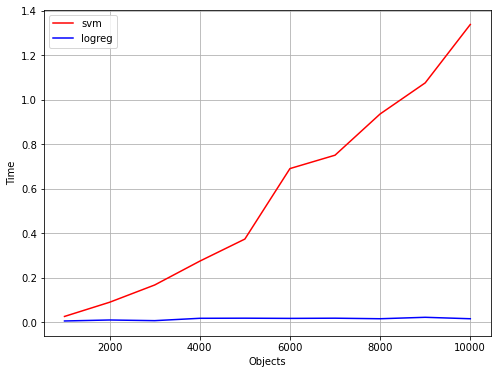

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(range(1000, 10001, 1000), svm_time, color='r', label='svm')
plt.plot(range(1000, 10001, 1000), logreg_time, color='b', label='logreg')
plt.grid(True) 
plt.ylabel('Time')
plt.xlabel('Objects')
plt.legend()
plt.show()

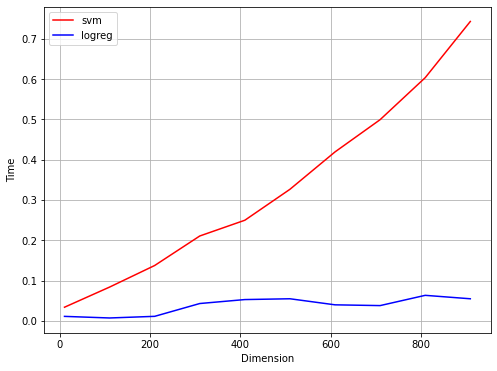

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(range(10, 1001, 100), svm_time_dim, color='r', label='svm')
plt.plot(range(10, 1001, 100), logreg_time_dim, color='b', label='logreg')
plt.grid(True) 
plt.ylabel('Time')
plt.xlabel('Dimension')
plt.legend()
plt.show()

**Вывод:** Это связано с применением RBF-ядра.

# 6. Уменьшение размерности входа (4 балла)

Если уменьшение числа объектов сложная и зачастую невозможная задача, то
    для понижения числа признаков существует стандартное решение. В предыдущих заданиях Вы уже сталкивались с l1-регуляризацией, которая позволяла уменьшить число признаков в задаче линейной классификации/регрессии. Однако для большинства ML-алгоритмов такой способ уменьшения числа признаков неприменим.
    
   Зато существует стандартное для всех алгоритмов понижение размерности входа. Данный алгоритм называется Principal Component Analysis (PCA, метод главных компонент). Он находит подпространство требуемой размерности $k$ ($k << d$, где d изначальная размерность входа), максимально сохраняющую дисперсию выборки, или, что то же самое, - сумма квадратов длин проекций объектов на которое будет минимальна. Подробнее об этом можете почитать тут https://scikit-learn.org/stable/modules/decomposition.html#pca. 
    
   **Эксперимент:** Проекция в очень малое число координат сильно "упрощает" выборку, из-за чего качество решения задачи может в итоге упасть. **В следующем эксперименте предлагается исследовать зависимость скорости работы метода и качества решения задачи при использовании понижения размерности. Требуется построить два графика:**

1. График зависимости времени работы всего цикла обучения от числа признаков $k$, которое остается после применения PCA. 
2. График зависимости качества решения (accuracy) задачи классификации от числа признаков $k$, которое остается после применения PCA.
    
При этом под полным циклом обучения подразумевается обучение PCA + обучение SVM. Данные для обучения: первые две координаты - луны, которые были в первом задании, а остальные координаты, случайные. 
Таким образом, без понижения размерности SVM с rbf ядром должен иметь точность близкую к 100\%. Чтобы лучше
видеть эффект на графиках, можете менять размер генерируемой выборки. Для данных размеров $k$ рекомендуется перебирать от 10 до 500 (тогда будет видна требуемая закономерность). 
    
   **P.S. Не забывайте делить выборку на обучение и валидацию в этом эксперименте** (так как мы смотрим на качество, мы хотим считать его честно). При этом PCA как и любой другой алгоритм ML тоже нельзя учить на тесте. Общая схема применения PCA описана в ячейках ниже. 

In [34]:
X_moons, y_moons = make_moons_cls(2000, 1000)

In [35]:
X_moons.shape

(2000, 1000)

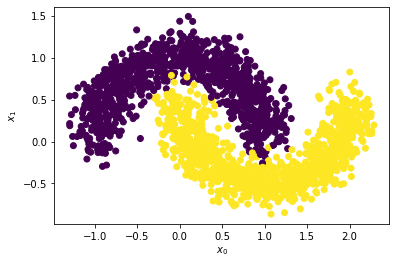

In [36]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

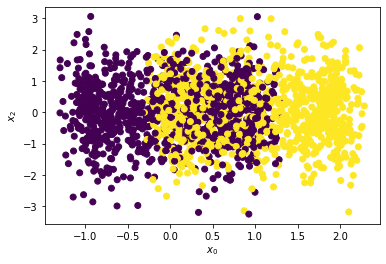

In [37]:
plt.scatter(X_moons[:, 0], X_moons[:, 2], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.show()

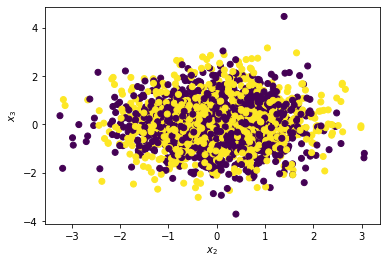

In [38]:
plt.scatter(X_moons[:, 2], X_moons[:, 3], c=y_moons)
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

Казалось бы понизить размерность в этой задаче достаточно легко, нужно просто выбрать только первые две координаты. Однако из-за нелинейности разделяющей поверхности, для PCA это задача нетривиальна. Такая же ситуация наблюдается и в большинстве прикладных задач. Теперь переходите **к эксперименту** :)

In [39]:
# Пример правильного обучения PCA с делением на train/test
pca_model = PCA(n_components=500)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
    X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма

print(X_moons.shape, y_moons.shape)
print(X_moons_train.shape, y_moons_train.shape)
print(X_train_for_pca.shape, y_train_for_pca.shape)

# Учим PCA
pca_model.fit(X_train_for_pca)

# Применяем PCA
X_moons_test_transformed = pca_model.transform(X_moons_test)
X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

print(X_train_for_svc_transformed.shape)

# Учим SVC (на другой выборке чтобы не переобучиться)
svc_on_transformed = SVC(kernel='rbf')
svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)

preds = svc_on_transformed.predict(X_moons_test_transformed)

print('Accuracy after PCA:', accuracy_score(preds, y_moons_test))

(2000, 1000) (2000,)
(1600, 1000) (1600,)
(800, 1000) (800,)
(800, 500)
Accuracy after PCA: 0.545


In [40]:
pca_time, accuracy = list(), list()
for n in range(10, 501, 10):
    pca_model = PCA(n_components=n)
    time_start = time.time()
    pca_model.fit(X_train_for_pca)
    X_moons_test_transformed = pca_model.transform(X_moons_test)
    X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)
    svc_on_transformed = SVC()
    svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)
    pca_time.append(time.time() - time_start)
    accuracy.append(accuracy_score(y_moons_test, svc_on_transformed.predict(X_moons_test_transformed)))

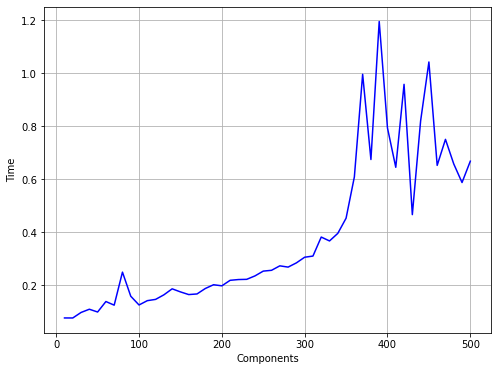

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(range(10, 501, 10), pca_time, color='b')
plt.ylabel('Time')
plt.xlabel('Components')
plt.grid()
plt.show()

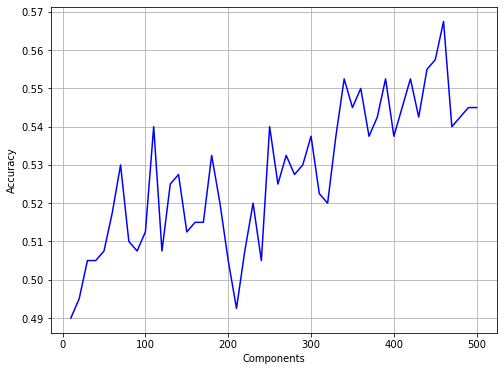

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(range(10, 501, 10), accuracy, color='b')
plt.ylabel('Accuracy')
plt.xlabel('Components')
plt.grid()
plt.show()

Опишите в выводе как ведет себя качество решения задачи и время работы в зависимости от числа компонент в PCA.  

**Вывод:** Чем больше компонент, тем выше точность и тем больше время работы

# 7. Калибровка вероятностей (3 балла)

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа model.decision_function(X). Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте визуализируем, как соотносится сортировка объектов по отступам с сортировкой
по таргету (классу). То есь построим кривую, в которой по оси X - доля выборки с отступом, меньшим чем данный,
по оси Y - доля объектов класса 1 с отступом, меньшим чем данный среди всех объектов класса 1.   

In [43]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

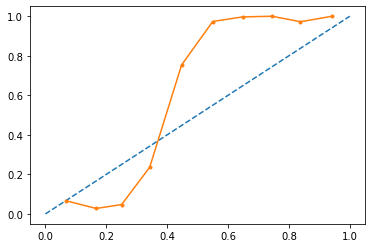

In [44]:

# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = SVC()
model.fit(trainX, trainy)
# predict probabilities
probs = model.decision_function(testX)
# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Для этого существует такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели. 

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [45]:
class CalibratingLogisticRegression:
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        self.logreg = LogisticRegression()
        self.logreg.fit(x[:, None], y)
        
    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        return self.logreg.predict_proba(x[:, None])[:, 1]

Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [46]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

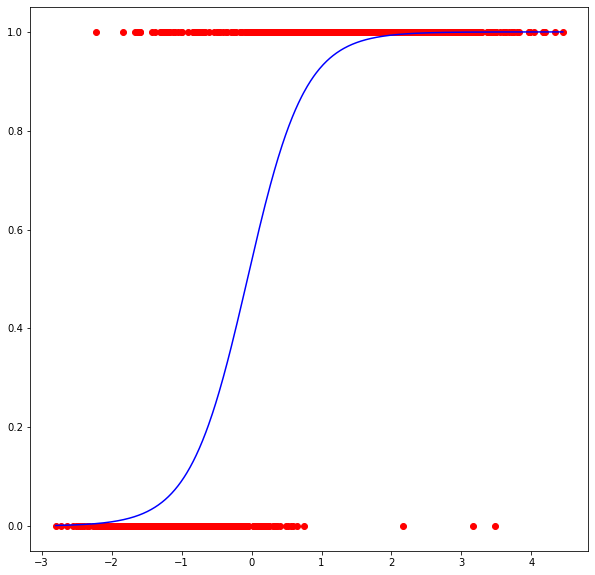

In [47]:
X_features_for_calibrating_model = model.decision_function(trainX[N:])


# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()
calibrating_model.fit(X_features_for_calibrating_model, trainy[N:])
prob = calibrating_model.predict_proba(X_features_for_calibrating_model)


# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(X_features_for_calibrating_model, prob)))
plt.figure(figsize=(10, 10))
plt.plot(X_features_for_calibrating_model, trainy[N:], 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.show()

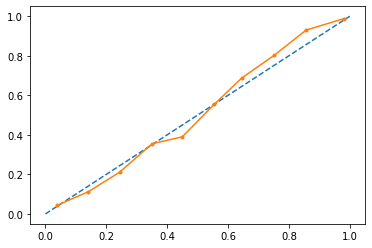

In [48]:
probs = calibrating_model.predict_proba(model.decision_function(testX))
# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Сделайте выводы о полученной модели. В каких задачах калибровка вероятностей могла бы быть полезной?

**Выводы:** Полученная модель может интерпретировать отступы как вероятности отнесения к классу, в отличие от изначальной SVM. Это может быть полезно, чтобы вручную задавать порог уверенности, начиная с которой мы будем относить объекты к тому или иному классу.

# Бонусное задание (2 балла)

Найдите мем про SVM

Вставьте его внешней ссылкой и проверьте, что в сгенерированном html он отображается


![texte](https://sun9-76.userapi.com/impg/HH8WZ9A_NgElpb3e97XJCjjn6bOBdKpNBPasqg/OkJtzPWk730.jpg?size=714x745&quality=96&sign=ab45773f3f94364ffb829f6c4a30214c&type=album)

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**